# Linear Regression

Try to apply a linear regression model to the merged otu table

In [1]:
import os
import csv
import logging

import biom
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import joblib
from dotenv import load_dotenv
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, ConfusionMatrixDisplay
from skbio.stats.composition import multiplicative_replacement, clr

from src import project_directory
from src.database import get_session, Sample

In [2]:
session = get_session()
logging.basicConfig()
logging.getLogger('sqlalchemy.engine.Engine').setLevel(logging.ERROR)
_ = load_dotenv()

Ok simply load otu table and then add tissue as metadata:

In [3]:
biom_file = project_directory / "merged_results/export/table/feature-table.biom"
table = biom.load_table(biom_file)

In [4]:
# Get the list of samples in the OTU table
samples = table.ids(axis='sample')
print(samples[:10])

['KR9NH_sample_100' 'KR9NH_sample_10' 'KR9NH_sample_11' 'KR9NH_sample_12'
 'KR9NH_sample_13' 'KR9NH_sample_14' 'KR9NH_sample_15' 'KR9NH_sample_16'
 'KR9NH_sample_17' 'KR9NH_sample_18']


In [5]:
# Query the database for samples in the samples list and collect the tissue
queried_samples = session.query(Sample).filter(Sample.sample_id.in_(samples)).all()
sample2tissue = {sample.sample_id: sample.dataset.tissue for sample in queried_samples}

In [6]:
# Create an empty dataframe with the same indices as the samples
metadata = pd.DataFrame(index=samples)

# Add the tissue as new metadata
metadata['tissue'] = metadata.index.map(sample2tissue)

# Update the OTU table with the new metadata
table.add_metadata(metadata.to_dict(orient='index'), axis='sample')

# Verify that the tissue has been added correctly
print(table.metadata(axis='sample')[:3])

(defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7faaf996a5c0>, {'tissue': 'gut'}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7faaf996a980>, {'tissue': 'gut'}), defaultdict(<function Table._cast_metadata.<locals>.cast_metadata.<locals>.<lambda> at 0x7faaf996aa20>, {'tissue': 'gut'}))


Transform the otu table to a pandas dataframe and then add the tissue as metadata.
Table should be transposed to have samples as rows and otus as columns.

In [7]:
# Convert the OTU table to a dataframe
otu_df = pd.DataFrame(table.matrix_data.toarray(), index=table.ids(axis='observation'), columns=table.ids(axis='sample'))

# Add the tissue metadata as a new column
otu_df = otu_df.transpose()
otu_df['tissue'] = otu_df.index.map(sample2tissue)

In [8]:
otu_df["tissue"].value_counts()

tissue
milk       535
rumen      146
hindgut    141
gut        100
feces       29
Name: count, dtype: int64

Transform tables:

In [9]:
X = otu_df.drop(columns=["tissue"])
y = otu_df["tissue"]

Convert counts to relative abundances:

In [10]:
X_relative = X.div(X.sum(axis=1), axis=0)

Split into train and test sets:

In [11]:
# random_state:
# https://stackoverflow.com/questions/28064634/random-state-pseudo-random-number-in-scikit-learn
X_train, X_test, y_train, y_test = train_test_split(X_relative, y, test_size=0.3, random_state=42)

deal with compositionality using clr transformation:

In [12]:
X_train_comp = multiplicative_replacement(X_train.values)
X_test_comp = multiplicative_replacement(X_test.values)

X_train_clr = clr(X_train_comp)
X_test_clr = clr(X_test_comp)

/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/skbio/util/_warning.py:42: DeprecationWarning: `multiplicative_replacement` was renamed to `multi_replace` in 0.6.0. The old name is kept as an alias but is deprecated.
  warn(message, warning)


## Creating a model

In [13]:
model = LogisticRegression(solver="liblinear", max_iter=int(os.getenv("MAX_ITER", 1000)))

In [14]:
param_grid = {'C': [0.01, 0.1, 1, 10, 100, 1000], 'penalty': ['l1', 'l2']}

In [15]:
grid_search = GridSearchCV(model, param_grid=param_grid, n_jobs=int(os.getenv("MAX_CPUS", -1)), verbose=1, cv=5)

In [16]:
grid_search.fit(X_train_clr, y_train)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=216016) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()
/home/cozzip/.cache/pypoetry/virtualenvs/deep-micro-core-QWG9m0ME-py3.12/lib/python3.12/site-packages/joblib/externals/loky/backend/fork_exec.py:38: DeprecationWarning: This process (pid=216016) is multi-threaded, use of fork() may lead to deadlocks in the child.
  pid = os.fork()


GridSearchCV(cv=5,
             estimator=LogisticRegression(max_iter=1000, solver='liblinear'),
             n_jobs=8,
             param_grid={'C': [0.01, 0.1, 1, 10, 100, 1000],
                         'penalty': ['l1', 'l2']},
             verbose=1)

In [17]:
grid_search.best_params_

{'C': 0.01, 'penalty': 'l2'}

In [18]:
y_pred = grid_search.predict(X_test_clr)

In [19]:
accuracy = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)

print(f"Accuracy: {accuracy}")
print("Classification Report:")
print(report)

Accuracy: 1.0
Classification Report:
              precision    recall  f1-score   support

       feces       1.00      1.00      1.00        10
         gut       1.00      1.00      1.00        33
     hindgut       1.00      1.00      1.00        32
        milk       1.00      1.00      1.00       164
       rumen       1.00      1.00      1.00        47

    accuracy                           1.00       286
   macro avg       1.00      1.00      1.00       286
weighted avg       1.00      1.00      1.00       286



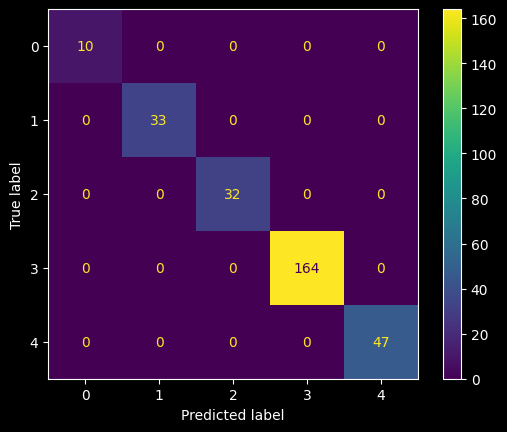

In [20]:
cm = confusion_matrix(y_test, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot()
plt.show()

The same confusion matrix as before but with class labels:

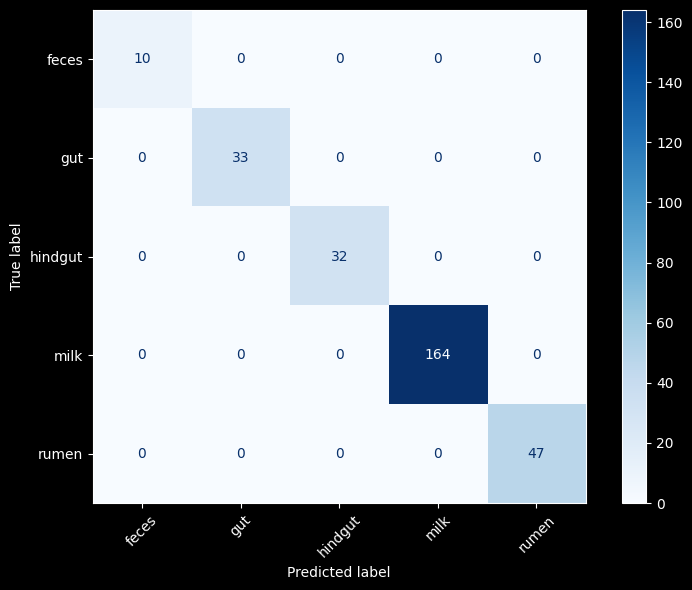

In [21]:
# fallback: unione ordinata di y_true e y_pred per garantire tutte le etichette
class_names = np.unique(np.concatenate([y_test.astype(str), y_pred.astype(str)]))

# Ricomponi la confusion matrix usando le etichette testuali e visualizza
cm = confusion_matrix(y_test, y_pred, labels=class_names)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)

fig, ax = plt.subplots(figsize=(8, 6))
disp.plot(ax=ax, xticks_rotation=45, cmap="Blues", values_format='d')
plt.tight_layout()
plt.show()

Get the best model and save it to a file:

In [22]:
best_model = grid_search.best_estimator_
joblib.dump(best_model, project_directory / "notebooks/logistic_regression_model.pkl")

['/home/cozzip/deep_micro_core/notebooks/logistic_regression_model.pkl']

Now try to collect the coefficients to identify the features that are more important for the model.

In [23]:
coefficients = best_model.coef_[0]
feature_importance = pd.DataFrame({'Feature ID': X.columns, 'Coefficient': coefficients})
feature_importance['Importance'] = np.abs(feature_importance['Coefficient'])
feature_importance.set_index('Feature ID', inplace=True)
feature_importance.sort_values(by='Importance', ascending=False, inplace=True)
feature_importance.head(10)

,Coefficient,Importance
Feature ID,,
5b37a813997329bf22271c78b63f03d9,-0.020907,0.020907
51ac26b0427099fce0010e287080fbd7,-0.020257,0.020257
26639d9f66c6c2106996b1c162605ff8,-0.019425,0.019425
b784d0c48f861b5580115402130a98cd,-0.016734,0.016734
3c097b9bdd9f25cb9d814d6ad2bbc325,-0.016734,0.016734
9fd944b60ec63ff4c85b3da3ebd73b10,-0.015386,0.015386
c9eb1ec1b179d48c1962fe348404dabe,-0.014191,0.014191
d8f7302f67ab8015d67c160aa96941d8,-0.013645,0.013645
4f3368941c23afc19f8f1761109dc7b4,-0.013262,0.013262


try to load the taxononies from file

In [24]:
taxonomy_file = project_directory / "merged_results/export/taxonomy/taxonomy.tsv"

with open(taxonomy_file, 'r') as handle:
    reader = csv.DictReader(handle, delimiter='\t')
    taxonomies = [row for row in reader]

taxonomies = {row['Feature ID']: row["Taxon"] for row in taxonomies}
taxonomies = {key: value.split(";")[:-1] for key, value in taxonomies.items()}
taxonomies = pd.DataFrame.from_dict(taxonomies, orient='index', columns=[f"Level_{i}" for i in range(1, 9)])
taxonomies.index.name = "Feature ID"
taxonomies.head()

,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,
00005da053b2c7b99c1f46889cbd7d33,Bacteria,Proteobacteria,Alphaproteobacteria,Rhodospirillales,,,,
000064ab480f315e268221d5ee0f9297,Bacteria,Firmicutes,Negativicutes,Veillonellales-Selenomonadales,Selenomonadaceae,Anaerovibrio,,
0000e116cc2f5406e876821a7c052ded,Bacteria,Chloroflexi,Chloroflexia,Chloroflexales,Roseiflexaceae,,,
00014fe9293f8f515587a4c2a3586c1b,Bacteria,,,,,,,
00020edaea2d646fb6acffceb62720ec,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotellaceae YAB2003 group,,


In [25]:
merged_df = feature_importance.merge(taxonomies, left_index=True, right_index=True, how="inner")
merged_df.to_csv(project_directory / "notebooks/feature_importance.csv", index=False)
merged_df.head()

,Coefficient,Importance,Level_1,Level_2,Level_3,Level_4,Level_5,Level_6,Level_7,Level_8
Feature ID,,,,,,,,,,
5b37a813997329bf22271c78b63f03d9,-0.020907,0.020907,Bacteria,,,,,,,
51ac26b0427099fce0010e287080fbd7,-0.020257,0.020257,Bacteria,,,,,,,
26639d9f66c6c2106996b1c162605ff8,-0.019425,0.019425,Archaea,Euryarchaeota,Methanobacteria,Methanobacteriales,Methanobacteriaceae,Methanobrevibacter,smithii,
b784d0c48f861b5580115402130a98cd,-0.016734,0.016734,Archaea,Thermoplasmatota,Thermoplasmata,Methanomassiliicoccales,Methanomethylophilaceae,Candidatus Methanomethylophilus,alvus,
3c097b9bdd9f25cb9d814d6ad2bbc325,-0.016734,0.016734,Bacteria,Bacteroidota,Bacteroidia,Bacteroidales,Prevotellaceae,Prevotella_9,,
